# Datos de los ligandos

## Obtención de los datos de los ligandos  cocristalizados con ERK2 desde Pubchem y Chembl

**Esta libreta tiene como objetivo extraer datos de las moléculas cocristalizadas con la proteína ERK2 a partir de las bases de datos CheMBL y PubChem**

> Puntos clave de esta libreta:
- Se extrae de la tabla de datos principal de la proteína las conformaciones que poseen a algún ligando en el sitio activo.
- Se crea un set de moléculas usando identificador PDB de cada molécula (cada molécula es designada con un id de 3 letras).
- Se usa el id de cada molécula (LIG) para obtener los datos de la página `http://www.rcsb.org/ligand/LIG`, correspondiente a cada ligando. Con ello obtenemos:
    - El smile isomérico de la molécula.
    - El InChI
    - El InChI Key
- Usamos el **InChI** para obtener los datos de cada molécula desde _**PUBCHEM**_ y _**CHEMBL**_.
- Guardamos los datos en un diccionario y a su vez lo exportamos a un archivo pinckle.

### Importamos las librerías necesarias

In [2]:
import pandas as pd
import numpy as np
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los arvhivos y módulos
sys.path.append(r'..')

## Cargamos los datos de la tabla principal
Nombre de laproteína:

In [20]:
# nombre de la proteína
prot_name = 'erk2'

In [9]:
# Cargamos el dataframe principal de la proteína
path_arguments = ('../data/TABLA_MTDATA_ERK2_166_crys_LIGS_INFO.json').split('/')
path_to_json_file = glob.glob(os.path.join(*path_arguments))[0]

df_prot_labels = pd.read_json(path_to_json_file)
df_prot_labels.shape

(166, 14)

**Esta tabla contiene ya la información de la molécula presente en el sitio activo de cada conformación de la proteína**

In [10]:
df_prot_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1erk,structure of signal-regulated kinase,1997-05-15,1,A,2.3,355,99.166667,1,[3],"[[1, 3]]",0,[],None,NaN
1gol,coordinates of rat map kinase erk2 with an arg...,1997-03-12,1,A,2.8,354,99.166667,1,[3],"[[1, 3]]",2,"[ATP, MG]",ATP,398.0
1pme,structure of penta mutant human erk2 map kinas...,1999-06-08,1,A,2.0,354,92.500000,4,"[15, 3, 1, 8]","[[1, 15], [33, 35], [161, 161], [330, 337]]",3,"[CME, SB2, SO4]",SB2,342.0


## Identificación de los inhibidores
### Seleccionamos las conformaciones que posean algun inhibidor

In [12]:
filtro_inh = df_prot_labels.Inhib.notnull()
df_ligs_crys = df_prot_labels[filtro_inh]
# Número total de conformaciones con algún ligando en el sitio activo
df_ligs_crys.shape

(138, 14)

In [13]:
print(F'{df_ligs_crys.shape[0]} conformaciones poseen algún ligando en el sitio activo.')

138 conformaciones poseen algún ligando en el sitio activo.


### Identificamos el número de ligandos únicos

In [14]:
ligs_crys_prot = set(df_ligs_crys.Inhib)
len(ligs_crys_prot)

118

## Comenzamos la obtención de los datos
El proceso es el siguiente:
> 1. Con el identificador de la molécula del PDB (nombe de tres letras, por ejemplo: ATP) se busca en el PDB la información de dicha molécula: http://www.rcsb.org/ligand
2. Se obtiene el *chemicalInChIKey*, el *chemicalInChI* y el SMILES isomérico de la molécula.
3. El *InChI el *InChIKey* o en su defecto el SMILES isimérico, es usado para buscar a la molécula en las bases de datos PubChem y Chembl.
    - Dichos *request* a la la API de cada base de datos se hacen con las librerías **_chembl_webresource_client_** y **_pubchemy_**.
4. Todos los datos disponibles de las moléculas son guardados en un diccionario de pyhton.
5. Finalmente el objeto se guarda en un archivo para posteriormente poder tener acceso al mismo.


### Web scrapping de los ligandos

In [15]:
# Librerías útiles para el web scrapping de los ligandos
import urllib.request
from bs4 import BeautifulSoup
from chembl_webresource_client.new_client import new_client
import pubchempy

In [16]:
# Url para accesar a la información de los ligandos en el PDB
URL_PDB = 'http://www.rcsb.org/ligand'

### Obtenemos los datos de cada ligando y los guardamos en un diccionario

In [17]:
# Generamos un diccionario con los datos de la molécula
dic_ligs_crys_prot = {}

for ligando in ligs_crys_prot:
    url_lig = F'{URL_PDB}/{ligando}'
    print(F'Procesando al ligando: {ligando}\n')
    
    # Extraemos los datos del html del ligando:
    lig_data = urllib.request.urlopen( url_lig ).read().decode()
    
    # Extraemos del bsoup los siguientes datos:
    # InChIKey
    soup = BeautifulSoup(lig_data)
    inchi_key = soup.find("tr", {"id": "chemicalInChIKey"})
    inchi_key_str = inchi_key.find('td').text
    
    # InChI
    inchi = soup.find("tr", {"id": "chemicalInChI"})
    inchi_str = inchi.find('td').text
    
    # isomeric SMILE (por si no se encuentra en la API de PbCh)
    smiles = soup.find("tr", {"id": "chemicalIsomeric"})
    smiles_str = smiles.find('td').text
    
    # Peso molecular
    mw = soup.find("tr", {"id": "chemicalMolecularWeight"})
    mw_str = mw.find('td').text
    
    # Con los datos anteriores usamos la librería para accesar al Chembl
    # **** CHEMBL ****
    # Procedemos a extraer los datos del Chembl
    molecule = new_client.molecule
    try:
        chblMol_info = molecule.get(inchi_key_str)
        chembl_id = chblMol_info['molecule_chembl_id']
    except:
        print(F'No se pudo obtener infor de CHEMBL: {ligando}')
        print(inchi_str + '\n')
        chblMol_info = None
        chembl_id = None
        
    # Ahora obtenemos datos correspondientes a pubchem
    # *** PUBCHEM ***
    try:
        pbch_mol = pubchempy.get_compounds(inchi_str, 'inchi')[0]
        pbch_cid = pbch_mol.cid
        pbch_data = pbch_mol.to_dict()
        canonical_smiles = pbch_mol.canonical_smiles
    except:
        print(F'Fallo con datos PUBCHEM: {ligando}')
        pbch_mol = None
        pbch_cid = None
        pbch_data = None
        canonical_smiles = None
    # Creamos la entrada para el diccionario
    # Primero el diccionario del ligando
    dic_lig = {'inchi_key': inchi_key_str,
               'inchi': inchi_str,
               'molecular_weight': float(mw_str),
               'canonical_smiles': canonical_smiles,
               'isomeric_similes': smiles_str,
               'chembl_id': chembl_id,
               'chembl_data': chblMol_info,
               'pubchem_id': pbch_cid,
               'pubchem_data': pbch_data,}
    
    # Anidamos el dict  del ligando al dic principal
    dic_ligs_crys_prot[ligando] = dic_lig

Procesando al ligando: HMY

No se pudo obtener infor de CEHMBL: HMY
InChI=1S/C19H22O8/c1-9-4-3-5-12(20)17(23)14(22)8-15-18(27-15)11-6-10(25-2)7-13(21)16(11)19(24)26-9/h3,5-7,9,14-15,17-18,21-23H,4,8H2,1-2H3/t9-,14-,15+,17+,18+/m0/s1

Procesando al ligando: 36O

Procesando al ligando: 36N

Procesando al ligando: TT4

No se pudo obtener infor de CEHMBL: TT4
InChI=1S/C8H9N5/c9-7-11-8(10)13(12-7)6-4-2-1-3-5-6/h1-5H,(H4,9,10,11,12)

Procesando al ligando: 362

Procesando al ligando: AOC

No se pudo obtener infor de CEHMBL: AOC
InChI=1S/C13H15N5O4/c1-2-3-21-4-7-9(19)10(20)13(22-7)18-6-17-8-11(14)15-5-16-12(8)18/h1,5-7,9-10,13,19-20H,3-4H2,(H2,14,15,16)/t7-,9-,10-,13-/m1/s1

Procesando al ligando: 36R

Procesando al ligando: ESN

No se pudo obtener infor de CEHMBL: ESN
InChI=1S/C29H32ClN5O4/c1-17-4-3-5-19(12-17)25(16-36)33-27(37)18(2)35-15-21-7-6-20(13-23(21)28(35)38)26-24(30)14-31-29(34-26)32-22-8-10-39-11-9-22/h3-7,12-14,18,22,25,36H,8-11,15-16H2,1-2H3,(H,33,37)(H,31,32,34)/t18-,25-/m1/s1



Procesando al ligando: E94

No se pudo obtener infor de CEHMBL: E94
InChI=1S/C28H27ClN6OS/c29-20-7-4-6-19(16-20)25-23(18-30)27(31-12-15-35-13-2-1-3-14-35)37-26(25)24-10-11-32-28(34-24)33-21-8-5-9-22(36)17-21/h4-11,16-17,31,36H,1-3,12-15H2,(H,32,33,34)

Procesando al ligando: EQT

Procesando al ligando: S91

No se pudo obtener infor de CEHMBL: S91
InChI=1S/C20H19N5O3/c1-12-3-2-4-15(9-12)23-19-16(18(21)28)11-22-20(25-19)24-14-7-5-13(6-8-14)10-17(26)27/h2-9,11H,10H2,1H3,(H2,21,28)(H,26,27)(H2,22,23,24,25)

Procesando al ligando: DJ2

No se pudo obtener infor de CEHMBL: DJ2
InChI=1S/C10H14N6O4/c11-8-5-9(14-2-13-8)16(3-15-5)10-7(18)6(17)4(20-10)1-19-12/h2-4,6-7,10,17-18H,1,12H2,(H2,11,13,14)/t4-,6-,7-,10-/m1/s1

Procesando al ligando: 2H1

No se pudo obtener infor de CEHMBL: 2H1
InChI=1S/C25H24N6O/c1-15(2)31-25-21(24(26)27-14-28-25)23(30-31)19-11-16(3)22-18(12-19)9-10-20(29-22)32-13-17-7-5-4-6-8-17/h4-12,14-15H,13H2,1-3H3,(H2,26,27,28)

Procesando al ligando: 6TS

No se pudo obtener infor d

## Guardamos el set de datos en formato *pickle*

In [18]:
import pickle

In [24]:
nombre_archivo = os.path.join('..','data', F'LIGS_{prot_name.upper()}_crys_pubchem_chembl_data.pkl')
if not os.path.exists(nombre_archivo):
    with open(nombre_archivo, 'wb') as dic_file:
        pickle.dump(dic_ligs_crys_prot, dic_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("El archivo ya ha sido creado.")

El archivo ya ha sido creado.


### Lectura del archivo guardado

In [26]:
# Lectura del diccionario con pickle
nombre_archivo = os.path.join('..','data', F'LIGS_{prot_name.upper()}_crys_pubchem_chembl_data.pkl')
with open(nombre_archivo, 'rb') as dic_file:
    dic_ligs_crys_prot = pickle.load(open(nombre_archivo, 'rb'))

In [27]:
# Número de ligandos procesados
len(dic_ligs_crys_prot)

118

# Finalmente:
## Uso del diccionario final
A modo de ejemplo visualizamos algunos de los datos disponibles en el diccionario:

In [28]:
import rdkit as rd

RDKit WARNING: [09:25:13] Enabling RDKit 2019.09.1 jupyter extensions


In [31]:
df_ligs_crys[df_ligs_crys.loc[:, 'Inhib'] == 'ATP']

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1gol,coordinates of rat map kinase erk2 with an arg...,1997-03-12,1,A,2.80,354,99.166667,1,[3],"[[1, 3]]",2,"[ATP, MG]",ATP,398.0
4gt3,atp-bound form of the erk2 kinase,2012-09-12,1,A,1.68,354,96.388889,3,"[10, 1, 2]","[[1, 10], [161, 161], [359, 360]]",5,"[ATP, CME, GOL, MG, PEG]",ATP,398.0


ID Chembl: CHEMBL14249
cid Pubchem: 5957
Nombre: ADENOSINE TRIPHOSPHATE


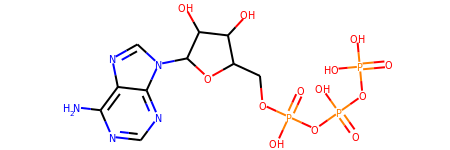

In [32]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1gol', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

ID Chembl: CHEMBL565459
Cid Pubchem: 44480711
Nombre: None


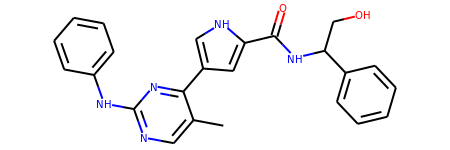

In [33]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['3i5z', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'Cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

# ¡Terminado!